In [2]:
import numpy as np
import pandas as pd

# preprocessing
import os
from datetime import datetime

# EDA
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats
from scipy.stats import skew
from scipy.stats import spearmanr

# Learning algorithms
import sklearn
from sklearn.linear_model import *
from sklearn.svm import SVR
from sklearn.cluster import KMeans

import lightgbm as lgb
from lightgbm import LGBMRegressor
# import catboost

# model validation
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

SEED = 2
np.random.seed(SEED)

In [3]:
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False 

#f_path = "c:/Windows/Fonts/AppleGothic.ttf"(맥)
f_path = "c:/Windows/Fonts/malgun.ttf"

font_name = font_manager.FontProperties(fname=f_path).get_name()
rc('font',family = font_name)

In [7]:
main_path = 'C:/Users/Playdata/Documents/DataScience/data/'
data_dir = 'energy/'
dir_path = f'{main_path}/{data_dir}'

test_name = 'test.csv'
train_name = 'train.csv'
building_name = 'building_info.csv'
sample_submission_name = 'sample_submission.csv'

In [8]:
def rename_dict(df):
    # 이름 정리
    targets = df.columns[df.columns.str.contains('\(')]
    if len(targets) == 7:
        df.rename(columns = {
            '기온(C)':'기온',
            '강수량(mm)':'강수량',
            '풍속(m/s)':'풍속',
            '습도(%)':'습도',
            '일조(hr)':'일조',
            '일사(MJ/m2)':'일사',
            '전력소비량(kWh)':'전력소비량'
        },inplace = True)
    elif len(targets) == 4:
        df.rename(columns = {
            '기온(C)':'기온',
            '강수량(mm)':'강수량',
            '풍속(m/s)':'풍속',
            '습도(%)':'습도',
        },inplace = True)
    else:
        df.rename(columns = {
            '연면적(m2)':'연면적',
            '냉방면적(m2)':'냉방면적', 
            '태양광용량(kW)':'태양광용량',
            'ESS저장용량(kWh)':'ESS저장용량',
            'PCS용량(kW)':'PCS용량'
        },inplace = True)
        
    return df

def data_datetime_setting(df):
    date_format = "%Y%m%d %H"
    # 일시 컬럼 이용하여 요일 확인
    df['요일'] = df['일시'].apply(lambda x: datetime.strptime(x, date_format).strftime("%a"))
    # 일시 컬럼 이용하여 연/월/일/시간 컬럼추가
    df['일시'] = pd.to_datetime(df['일시'], format='%Y%m%d %H')
    df['연'] = df['일시'].dt.year
    df['월'] = df['일시'].dt.month
    df['일'] = df['일시'].dt.day
    df['시간'] = df['일시'].dt.hour
    return df

def data_preprocessing(df):
    try:
        df['강수량(mm)'].fillna(0, inplace=True)
        df['풍속(m/s)'].fillna(method='ffill', inplace=True)
        df['습도(%)'].fillna(method='ffill', inplace=True)
        df['일조(hr)'].fillna(0, inplace=True)
        df['일사(MJ/m2)'].fillna(0, inplace=True)
    except:
        df['강수량(mm)'].fillna(0, inplace=True)
        df['일조(hr)'] = 0
        df['일사(MJ/m2)'] = 0
    return df

In [9]:
os.listdir(dir_path)

['building_info.csv', 'sample_submission.csv', 'test.csv', 'train.csv']

In [10]:
test_df = pd.read_csv(f'{dir_path}/{test_name}')
train_df = pd.read_csv(f'{dir_path}/{train_name}')
building_df = pd.read_csv(f'{dir_path}/{building_name}')

In [11]:
train_df = rename_dict(df = train_df)
train_df = data_datetime_setting(df=train_df)

building_df = rename_dict(df = building_df)

In [12]:
merge_df = train_df.merge(building_df)
for col in merge_df.columns:
    merge_df[col] = merge_df[col].replace('-',0)
    merge_df[col] = merge_df[col].fillna(0)
    
merge_df['태양광용량'] = merge_df['태양광용량'].astype('float64')
merge_df['ESS저장용량'] = merge_df['ESS저장용량'].astype('float64')
merge_df['PCS용량'] = merge_df['PCS용량'].astype('float64')
merge_df.drop(['num_date_time','일시'],axis=1,inplace=True) # 둘 다 없어도 알 수 있는 데이터라서

# 요일, 건물유형은 원핫인코딩하기 > pd.get_dummies()


In [35]:
from sklearn.model_selection import train_test_split
X = merge_df.loc[:,merge_df.drop('전력소비량',axis=1).columns.values]
X = pd.get_dummies(X) # 요일, 건물유형
y = merge_df.loc[:,'건물번호']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.3,shuffle=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.58s/it]


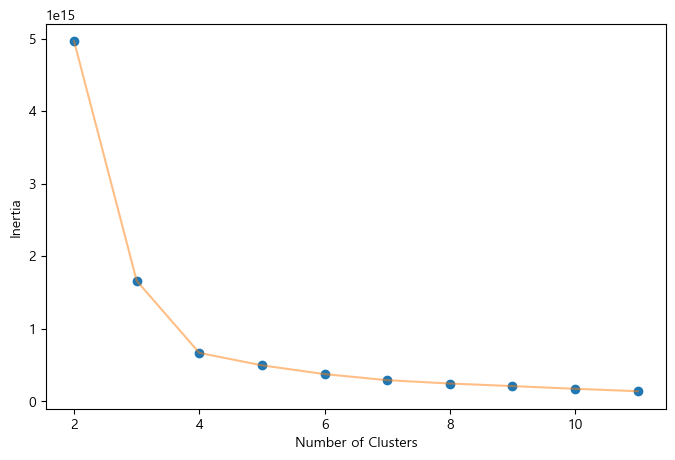

In [36]:
from tqdm import tqdm
def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in tqdm(n_clusters):
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)
        
    plt.figure(1 , figsize = (8, 5))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

change_n_clusters([2,3,4,5,6,7,8,9,10,11], X)

- n_클러스터 3과 4가 비슷하다 > 두개의 값 모두 계산해보고 더 최적인거 선택하기

In [37]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
print(np.unique(kmeans.labels_,return_counts=True))
merge_df['label'] = kmeans.labels_
merge_df

(array([0, 1, 2, 3]), array([134640,   2040,   8160,  59160], dtype=int64))


,건물번호,기온,강수량,풍속,습도,일조,일사,전력소비량,요일,연,월,일,시간,건물유형,연면적,냉방면적,태양광용량,ESS저장용량,PCS용량,label
0,1,18.6,0.0,0.9,42.0,0.0,0.0,1085.28,Wed,2022,6,1,0,건물기타,110634.00,39570.00,0.0,0.0,0.0,0
1,1,18.0,0.0,1.1,45.0,0.0,0.0,1047.36,Wed,2022,6,1,1,건물기타,110634.00,39570.00,0.0,0.0,0.0,0
2,1,17.7,0.0,1.5,45.0,0.0,0.0,974.88,Wed,2022,6,1,2,건물기타,110634.00,39570.00,0.0,0.0,0.0,0
3,1,16.7,0.0,1.4,48.0,0.0,0.0,953.76,Wed,2022,6,1,3,건물기타,110634.00,39570.00,0.0,0.0,0.0,0
4,1,18.4,0.0,2.8,43.0,0.0,0.0,986.40,Wed,2022,6,1,4,건물기타,110634.00,39570.00,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100,23.1,0.0,0.9,86.0,0.5,0.0,881.04,Wed,2022,8,24,19,호텔및리조트,57497.84,40035.23,0.0,0.0,0.0,0
203996,100,22.4,0.0,1.3,86.0,0.0,0.0,798.96,Wed,2022,8,24,20,호텔및리조트,57497.84,40035.23,0.0,0.0,0.0,0
203997,100,21.3,0.0,1.0,92.0,0.0,0.0,825.12,Wed,2022,8,24,21,호텔및리조트,57497.84,40035.23,0.0,0.0,0.0,0
203998,100,21.0,0.0,0.3,94.0,0.0,0.0,640.08,Wed,2022,8,24,22,호텔및리조트,57497.84,40035.23,0.0,0.0,0.0,0


In [42]:
list = merge_df[merge_df['label']==4]
list['건물유형'].unique()

array([], dtype=object)

In [43]:
merge_df.corr()

,건물번호,기온,강수량,풍속,습도,일조,일사,전력소비량,연,월,일,시간,연면적,냉방면적,태양광용량,ESS저장용량,PCS용량,label
건물번호,1.000000e+00,-0.004505,-0.004135,0.021413,0.022798,0.017324,-0.009030,-0.180474,NaN,-2.790756e-14,3.608018e-15,-3.480358e-15,-1.153222e-01,-1.161989e-01,-4.556644e-02,-1.246762e-01,-1.722903e-01,-6.175171e-02
기온,-4.504794e-03,1.000000,-0.068643,0.220072,-0.389585,0.419242,0.463308,0.171190,NaN,4.271998e-01,6.949836e-02,2.914288e-01,-3.338348e-03,-3.055486e-03,6.433531e-03,1.105861e-02,8.055456e-03,7.338981e-03
강수량,-4.134622e-03,-0.068643,1.000000,0.048103,0.199491,-0.100483,-0.099372,0.015083,NaN,4.343621e-02,2.710738e-02,1.372893e-02,-2.632912e-03,-2.753116e-03,5.574572e-03,4.214705e-03,5.436438e-03,3.001043e-03
풍속,2.141270e-02,0.220072,0.048103,1.000000,-0.218568,0.167946,0.225497,0.109956,NaN,-8.638854e-02,1.002829e-01,1.770734e-01,-5.499032e-02,-5.376845e-02,-5.030717e-02,-3.659568e-03,-1.257501e-02,-3.026969e-03
습도,2.279767e-02,-0.389585,0.199491,-0.218568,1.000000,-0.571982,-0.560771,-0.129373,NaN,2.537476e-01,1.184344e-01,-2.803901e-01,-2.007649e-02,-2.047581e-02,-7.470715e-04,-4.688005e-02,-4.912406e-02,-5.071685e-02
일조,1.732413e-02,0.419242,-0.100483,0.167946,-0.571982,1.000000,0.764701,0.094748,NaN,-4.952327e-02,-7.541481e-02,1.597529e-01,3.834039e-03,4.099886e-03,-1.532711e-02,-8.744071e-03,-9.407145e-03,-9.182984e-03
일사,-9.029883e-03,0.463308,-0.099372,0.225497,-0.560771,0.764701,1.000000,0.177750,NaN,-3.801214e-02,-5.684107e-02,1.529886e-01,-6.575582e-02,-6.482553e-02,-1.983026e-02,1.128895e-02,1.091857e-02,-1.003253e-02
전력소비량,-1.804737e-01,0.171190,0.015083,0.109956,-0.129373,0.094748,0.177750,1.000000,NaN,5.584234e-02,9.233027e-03,9.959427e-02,1.346303e-02,1.644439e-02,5.203917e-02,-3.185621e-02,-3.388190e-02,1.269271e-01
연,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
월,-2.790756e-14,0.427200,0.043436,-0.086389,0.253748,-0.049523,-0.038012,0.055842,NaN,1.000000e+00,-1.333186e-01,-8.672975e-17,5.220941e-15,5.223730e-15,3.273456e-15,6.512695e-15,8.584910e-15,2.702005e-15


#############여기서부턴 지워도 됩니다##############

In [15]:
cl_df_list = []
for i in range(0,len(cl_df)):
    cl_df_list.append(cl_df.iloc[i].to_list())
cl_df_list

# kmeans.itertia_:  군집의 중심과 각 케이스(개체) 간에 거리를 계산합니다. 
# 중심과 개체간의 거리가 작아진다는 것은 그만큼 군집이 잘 형성이 되었다는 것입니다.

wcss = []

for i in range(1,21):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit_transform(cl_df)
    wcss.append(kmeans.inertia_)

wcss

plt.figure()
plt.plot(range(1, 21), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

NameError: name 'cl_df' is not defined

In [ ]:
def visualize_silhouette_layer(data, param_init='random', param_n_init=10, param_max_iter=300):
    clusters_range = range(2,21)
    results = []

    for i in clusters_range:
        clusterer = KMeans(n_clusters=i, init=param_init, n_init=param_n_init, max_iter=param_max_iter, random_state=0)
        cluster_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

    plt.figure()
    sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm._rocket_lut)
    plt.tight_layout()
    plt.show()

In [ ]:
colormap = plt.cm.gist_heat # 그래프의 색상
plt.figure(figsize = (12,12))
# vmax 값을 0.5로 지정해 0.5에 가까울수록 밝은색으로 표시
sns.heatmap(df.corr(), linewidths = 0.1, vmax = 0.5, cmap = colormap,
            linecolor = 'white', annot = True)
plt.show()
# plasma, bmi가 상관관계가 높은 것을 알 수 있다.

In [22]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(X_train)

train_scaled = ss.transform(X_train)
test_scaled = ss.transform(X_test)

ValueError: could not convert string to float: 'Thu'